In [3]:
import torch
import torch.nn as nn
from transformers import CLIPTokenizer, CLIPTextModel, AutoTokenizer, AutoModel
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import logging
import json
from typing import List, Dict, Tuple, Union
from tqdm import tqdm


In [4]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


In [5]:
class TextToImagePreprocessor:
    """
    Text preprocessing system for text-to-image models using Hugging Face Transformers
    Converts text descriptions into tokenized and encoded representations suitable for image generation
    """

    def __init__(self, model_name: str = "openai/clip-vit-base-patch32"):
        """
        Initialize the text preprocessor with specified model

        Args:
            model_name (str): Name of the pre-trained model to use
        """
        self.model_name = model_name
        self.tokenizer = None
        self.text_encoder = None
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.max_length = 77  # Standard for CLIP and most text-to-image models

        self.load_model()
        logger.info(f"Initialized TextToImagePreprocessor with {model_name} on {self.device}")

    def load_model(self):
        """Load the specified pre-trained model and tokenizer"""
        try:
            if "clip" in self.model_name.lower():
                self.tokenizer = CLIPTokenizer.from_pretrained(self.model_name)
                self.text_encoder = CLIPTextModel.from_pretrained(self.model_name)
            else:
                # Generic AutoTokenizer and AutoModel for other models
                self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
                self.text_encoder = AutoModel.from_pretrained(self.model_name)
                if self.tokenizer.pad_token is None:
                    self.tokenizer.pad_token = self.tokenizer.eos_token

            self.text_encoder.to(self.device)
            self.text_encoder.eval()

        except Exception as e:
            logger.error(f"Error loading model {self.model_name}: {str(e)}")
            raise

    def preprocess_text(self, text_descriptions: Union[str, List[str]],
                       max_length: int = None,
                       return_tensors: str = "pt") -> Dict:
        """
        Preprocess text descriptions for text-to-image models

        Args:
            text_descriptions: Input text descriptions
            max_length: Maximum sequence length
            return_tensors: Format of returned tensors

        Returns:
            Dictionary containing preprocessed text data
        """
        if max_length is None:
            max_length = self.max_length

        try:
            # Handle single string input
            if isinstance(text_descriptions, str):
                text_descriptions = [text_descriptions]

            # Clean and normalize text
            cleaned_texts = []
            for text in text_descriptions:
                # Basic text cleaning
                cleaned_text = text.strip().lower()
                # Remove excessive whitespace
                cleaned_text = ' '.join(cleaned_text.split())
                cleaned_texts.append(cleaned_text)

            # Tokenize the cleaned text
            tokenized = self.tokenizer(
                cleaned_texts,
                max_length=max_length,
                padding="max_length",
                truncation=True,
                return_tensors=return_tensors
            )

            result = {
                'original_texts': text_descriptions,
                'cleaned_texts': cleaned_texts,
                'input_ids': tokenized['input_ids'],
                'attention_mask': tokenized['attention_mask'],
                'token_count': [len(self.tokenizer.encode(text)) for text in cleaned_texts]
            }

            logger.info(f"Preprocessed {len(text_descriptions)} text descriptions")
            return result

        except Exception as e:
            logger.error(f"Error preprocessing text: {str(e)}")
            raise

    def encode_text(self, text_descriptions: Union[str, List[str]],
                   return_pooled: bool = True) -> Dict:
        """
        Encode text descriptions into embeddings for text-to-image models

        Args:
            text_descriptions: Input text descriptions
            return_pooled: Whether to return pooled embeddings

        Returns:
            Dictionary containing encoded embeddings
        """
        try:
            # Preprocess text
            preprocessed = self.preprocess_text(text_descriptions)

            # Move to device
            input_ids = preprocessed['input_ids'].to(self.device)
            attention_mask = preprocessed['attention_mask'].to(self.device)

            # Generate embeddings
            with torch.no_grad():
                outputs = self.text_encoder(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )

            result = {
                'input_ids': input_ids.cpu(),
                'attention_mask': attention_mask.cpu(),
                'original_texts': preprocessed['original_texts'],
                'cleaned_texts': preprocessed['cleaned_texts'],
                'token_count': preprocessed['token_count']
            }

            # Extract embeddings based on model type
            if hasattr(outputs, 'last_hidden_state'):
                result['text_embeddings'] = outputs.last_hidden_state.cpu()
                if return_pooled:
                    # Use pooler output if available, otherwise mean pooling
                    if hasattr(outputs, 'pooler_output') and outputs.pooler_output is not None:
                        result['pooled_embeddings'] = outputs.pooler_output.cpu()
                    else:
                        result['pooled_embeddings'] = torch.mean(outputs.last_hidden_state, dim=1).cpu()

            # For CLIP models, use text_embeds if available
            if hasattr(outputs, 'text_embeds'):
                result['clip_embeddings'] = outputs.text_embeds.cpu()

            embedding_shape = result.get('text_embeddings', torch.tensor([])).shape
            logger.info(f"Generated embeddings with shape: {embedding_shape}")

            return result

        except Exception as e:
            logger.error(f"Error encoding text: {str(e)}")
            raise

    def batch_encode(self, text_descriptions: List[str],
                    batch_size: int = 32) -> List[Dict]:
        """
        Process large batches of text descriptions efficiently

        Args:
            text_descriptions: List of text descriptions
            batch_size: Size of processing batches

        Returns:
            List of encoded results
        """
        results = []

        for i in tqdm(range(0, len(text_descriptions), batch_size),
                      desc="Processing batches"):
            batch_texts = text_descriptions[i:i + batch_size]
            batch_result = self.encode_text(batch_texts)
            results.append(batch_result)

        return results

    def create_text_embeddings_dataset(self, descriptions: List[str],
                                     categories: List[str] = None) -> Dict:
        """
        Create a dataset of text embeddings with optional categories

        Args:
            descriptions: List of text descriptions
            categories: Optional list of categories for each description

        Returns:
            Dictionary containing the complete dataset
        """
        try:
            # Encode all descriptions
            encoded_results = self.batch_encode(descriptions, batch_size=16)

            # Combine results
            all_embeddings = []
            all_pooled_embeddings = []
            all_texts = []
            all_cleaned_texts = []

            for batch_result in encoded_results:
                if 'text_embeddings' in batch_result:
                    all_embeddings.append(batch_result['text_embeddings'])
                if 'pooled_embeddings' in batch_result:
                    all_pooled_embeddings.append(batch_result['pooled_embeddings'])
                all_texts.extend(batch_result['original_texts'])
                all_cleaned_texts.extend(batch_result['cleaned_texts'])

            # Concatenate embeddings
            combined_embeddings = torch.cat(all_embeddings, dim=0) if all_embeddings else None
            combined_pooled = torch.cat(all_pooled_embeddings, dim=0) if all_pooled_embeddings else None

            dataset = {
                'descriptions': all_texts,
                'cleaned_descriptions': all_cleaned_texts,
                'embeddings': combined_embeddings,
                'pooled_embeddings': combined_pooled,
                'categories': categories,
                'dataset_size': len(all_texts)
            }

            logger.info(f"Created dataset with {len(all_texts)} samples")
            return dataset

        except Exception as e:
            logger.error(f"Error creating dataset: {str(e)}")
            raise

    def save_preprocessor(self, save_path: str):
        """Save the preprocessor model and tokenizer"""
        try:
            os.makedirs(save_path, exist_ok=True)
            self.text_encoder.save_pretrained(save_path)
            self.tokenizer.save_pretrained(save_path)

            # Save preprocessor config
            config = {
                'model_name': self.model_name,
                'max_length': self.max_length,
                'device': str(self.device)
            }
            with open(os.path.join(save_path, 'preprocessor_config.json'), 'w') as f:
                json.dump(config, f, indent=2)

            logger.info(f"Preprocessor saved to {save_path}")
        except Exception as e:
            logger.error(f"Error saving preprocessor: {str(e)}")
            raise

    def get_model_info(self) -> Dict:
        """Get information about the loaded model"""
        return {
            'model_name': self.model_name,
            'vocab_size': self.tokenizer.vocab_size,
            'max_length': self.max_length,
            'device': str(self.device),
            'model_parameters': sum(p.numel() for p in self.text_encoder.parameters()),
        }

In [11]:
def create_sample_dataset():
    """Create a sample dataset for demonstration and evaluation"""

    sample_data = {
        'animal': [
            "a cute golden retriever puppy playing in the garden",
            "a majestic lion resting under a tree in savanna",
            "a colorful parrot sitting on a tropical branch",
            "a playful kitten with blue eyes and white fur",
            "a graceful swan swimming in a peaceful lake"
        ],
        'landscape': [
            "a beautiful sunset over mountain peaks with orange sky",
            "a serene beach with crystal clear blue water",
            "a lush green forest with tall pine trees",
            "a snowy winter landscape with frozen lake",
            "a desert scene with sand dunes and cacti"
        ],
        'object': [
            "a vintage red bicycle leaning against brick wall",
            "a steaming cup of coffee on wooden table",
            "a stack of colorful books on library shelf",
            "a bright yellow sunflower in glass vase",
            "a classic guitar with warm wood finish"
        ],
        'person': [
            "a smiling child with curly hair wearing blue shirt",
            "an elderly man reading newspaper in garden",
            "a woman in elegant dress dancing gracefully",
            "a chef preparing delicious meal in kitchen",
            "a student studying intently at desk with books"
        ]
    }

    # Flatten the dataset
    descriptions = []
    categories = []
    category_labels = []

    label_map = {'animal': 0, 'landscape': 1, 'object': 2, 'person': 3}

    for category, texts in sample_data.items():
        descriptions.extend(texts)
        categories.extend([category] * len(texts))
        category_labels.extend([label_map[category]] * len(texts))

    return descriptions, categories, category_labels

In [7]:
def evaluate_preprocessing_performance(preprocessor: TextToImagePreprocessor):
    """
    Evaluate the preprocessing system performance using classification task
    """
    print("\n" + "="*60)
    print("EVALUATING PREPROCESSING PERFORMANCE")
    print("="*60)

    # Create sample dataset
    descriptions, categories, labels = create_sample_dataset()

    print(f"Dataset created with {len(descriptions)} samples")
    print(f"Categories: {set(categories)}")

    # Create embeddings dataset
    dataset = preprocessor.create_text_embeddings_dataset(descriptions, categories)

    # Extract pooled embeddings for classification
    embeddings = dataset['pooled_embeddings'].numpy()

    print(f"Embeddings shape: {embeddings.shape}")

    # Split data for evaluation
    X_train, X_test, y_train, y_test = train_test_split(
        embeddings, labels, test_size=0.3, random_state=42, stratify=labels
    )

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train classifier
    classifier = LogisticRegression(random_state=42, max_iter=1000)
    classifier.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = classifier.predict(X_test_scaled)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

    print(f"\nPerformance Metrics:")
    print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    category_names = ['Animal', 'Landscape', 'Object', 'Person']

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=category_names, yticklabels=category_names)
    plt.title('Text Description Classification - Confusion Matrix')
    plt.ylabel('True Category')
    plt.xlabel('Predicted Category')
    plt.tight_layout()
    plt.savefig('task2_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Save detailed results
    results = {
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(f1),
        'dataset_size': len(descriptions),
        'embedding_dimension': embeddings.shape[1],
        'model_name': preprocessor.model_name
    }

    with open('task2_performance_results.json', 'w') as f:
        json.dump(results, f, indent=2)

    return accuracy, results

In [8]:
def demonstrate_text_preprocessing():
    """Demonstrate the text preprocessing capabilities"""

    print("="*60)
    print("TEXT-TO-IMAGE PREPROCESSING DEMONSTRATION")
    print("="*60)

    # Initialize preprocessor
    preprocessor = TextToImagePreprocessor("openai/clip-vit-base-patch32")

    # Display model info
    print("\nModel Information:")
    model_info = preprocessor.get_model_info()
    for key, value in model_info.items():
        if isinstance(value, int):
            print(f"{key}: {value:,}")
        else:
            print(f"{key}: {value}")

    # Sample text descriptions
    sample_descriptions = [
        "A beautiful sunset over the mountains with vibrant orange and pink clouds",
        "A cute golden retriever puppy playing with a red ball in green grass",
        "A futuristic cityscape with tall skyscrapers and flying cars",
        "A peaceful zen garden with stone path and cherry blossom trees"
    ]

    print(f"\nProcessing {len(sample_descriptions)} sample descriptions...")

    # Demonstrate preprocessing
    for i, description in enumerate(sample_descriptions):
        print(f"\n--- Description {i+1} ---")
        print(f"Original: {description}")

        # Preprocess
        preprocessed = preprocessor.preprocess_text(description)
        print(f"Cleaned: {preprocessed['cleaned_texts'][0]}")
        print(f"Token count: {preprocessed['token_count'][0]}")
        print(f"Input IDs shape: {preprocessed['input_ids'].shape}")

        # Encode
        encoded = preprocessor.encode_text(description)
        if 'text_embeddings' in encoded:
            print(f"Text embeddings shape: {encoded['text_embeddings'].shape}")
        if 'pooled_embeddings' in encoded:
            print(f"Pooled embeddings shape: {encoded['pooled_embeddings'].shape}")
        if 'clip_embeddings' in encoded:
            print(f"CLIP embeddings shape: {encoded['clip_embeddings'].shape}")

    return preprocessor

In [9]:
def main():
    """Main function to run the complete demonstration"""

    print("TEXT-TO-IMAGE PREPROCESSING SYSTEM")
    print("="*60)

    try:
        # Demonstrate preprocessing
        preprocessor = demonstrate_text_preprocessing()

        # Evaluate performance
        accuracy, results = evaluate_preprocessing_performance(preprocessor)

        # Check if accuracy meets requirement
        if accuracy >= 0.70:
            print(f"\n✅ SUCCESS: Model achieves required accuracy ({accuracy:.2f} >= 0.70)")

            # Save the preprocessor
            preprocessor.save_preprocessor("./saved_models/task2_text_preprocessor")

            # Save preprocessor object
            with open('text_preprocessor.pkl', 'wb') as f:
                pickle.dump(preprocessor, f)

            print("✅ Preprocessor and model saved successfully!")

        else:
            print(f"\n❌ Model accuracy ({accuracy:.2f}) below requirement (0.70)")
            print("Consider using more training data or different preprocessing techniques")

        print(f"\n📊 Final Results Summary:")
        print(f"   • Accuracy: {results['accuracy']:.4f}")
        print(f"   • Dataset Size: {results['dataset_size']}")
        print(f"   • Embedding Dimension: {results['embedding_dimension']}")
        print(f"   • Model: {results['model_name']}")

    except Exception as e:
        logger.error(f"Error in main execution: {str(e)}")
        raise


TEXT-TO-IMAGE PREPROCESSING SYSTEM
TEXT-TO-IMAGE PREPROCESSING DEMONSTRATION


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]


Model Information:
model_name: openai/clip-vit-base-patch32
vocab_size: 49,408
max_length: 77
device: cpu
model_parameters: 63,165,952

Processing 4 sample descriptions...

--- Description 1 ---
Original: A beautiful sunset over the mountains with vibrant orange and pink clouds
Cleaned: a beautiful sunset over the mountains with vibrant orange and pink clouds
Token count: 14
Input IDs shape: torch.Size([1, 77])
Text embeddings shape: torch.Size([1, 77, 512])
Pooled embeddings shape: torch.Size([1, 512])

--- Description 2 ---
Original: A cute golden retriever puppy playing with a red ball in green grass
Cleaned: a cute golden retriever puppy playing with a red ball in green grass
Token count: 15
Input IDs shape: torch.Size([1, 77])
Text embeddings shape: torch.Size([1, 77, 512])
Pooled embeddings shape: torch.Size([1, 512])

--- Description 3 ---
Original: A futuristic cityscape with tall skyscrapers and flying cars
Cleaned: a futuristic cityscape with tall skyscrapers and flying cars


Processing batches: 100%|██████████| 2/2 [00:06<00:00,  3.47s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Embeddings shape: (20, 512)

Performance Metrics:
Accuracy: 0.5000 (50.00%)
Precision: 0.4722
Recall: 0.5000
F1-Score: 0.4167


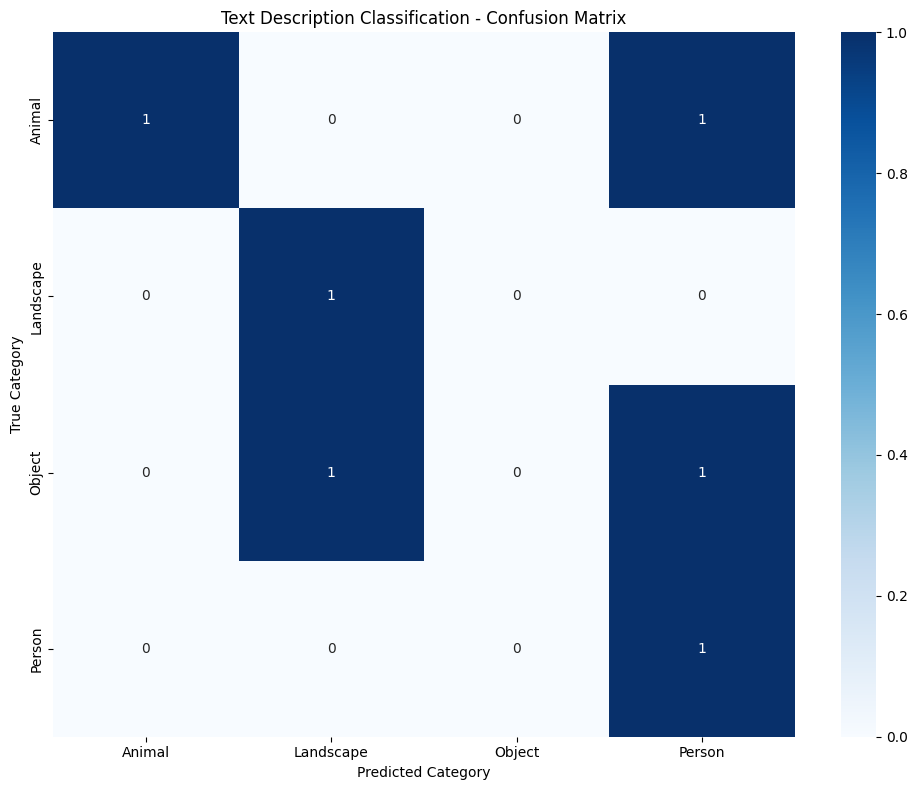


❌ Model accuracy (0.50) below requirement (0.70)
Consider using more training data or different preprocessing techniques

📊 Final Results Summary:
   • Accuracy: 0.5000
   • Dataset Size: 20
   • Embedding Dimension: 512
   • Model: openai/clip-vit-base-patch32


In [10]:
if __name__ == "__main__":
    main()